In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [2]:
model_folder = os.getenv("RESNET_MODEL_FOLDER")
print(model_folder)

target_class = -1

/rds/general/user/nk1924/home/shared_models/cifar10/adam_augbasic_cosine-60-0.0_wd0.01_resnet18repr-128_cifar10_lr0.001_s0


In [3]:
from nadf.data.adversarial import load_or_create_dataset

dataset = load_or_create_dataset(
    folder=model_folder,
    target_class=target_class,
    num_attacks_eps_coef=[(4, 0.25), (2, 0.5), (3, 1.0), (1, 2.0)],
    recreate=False,
    verbose=False,
)

Loading cached dataset from /rds/general/user/nk1924/home/shared_models/cifar10/adam_augbasic_cosine-60-0.0_wd0.01_resnet18repr-128_cifar10_lr0.001_s0/adversarial_examples/attacks/pgd_l2_4x0.25_2x0.5_3x1.0_1x2.0/target_-1.pkl


In [4]:
dataset.keys()

dict_keys(['x', 'y', 'z', 'x_clean', 'y_clean', 'z_clean', 'x_adv', 'y_adv', 'z_adv', 'z_clean_pool', 'y_clean_pool', 'pred_clean', 'eps_coef_adv', 'eps_coef_combined', 'pred_adv', 'pred_combined'])

In [5]:
print(dataset.keys())
print(dataset["y"]["train"].unique())
print(dataset["y"]["val"].unique())
print(dataset["y"]["test"].unique())



dict_keys(['x', 'y', 'z', 'x_clean', 'y_clean', 'z_clean', 'x_adv', 'y_adv', 'z_adv', 'z_clean_pool', 'y_clean_pool', 'pred_clean', 'eps_coef_adv', 'eps_coef_combined', 'pred_adv', 'pred_combined'])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


## Visualize Misclassification trends

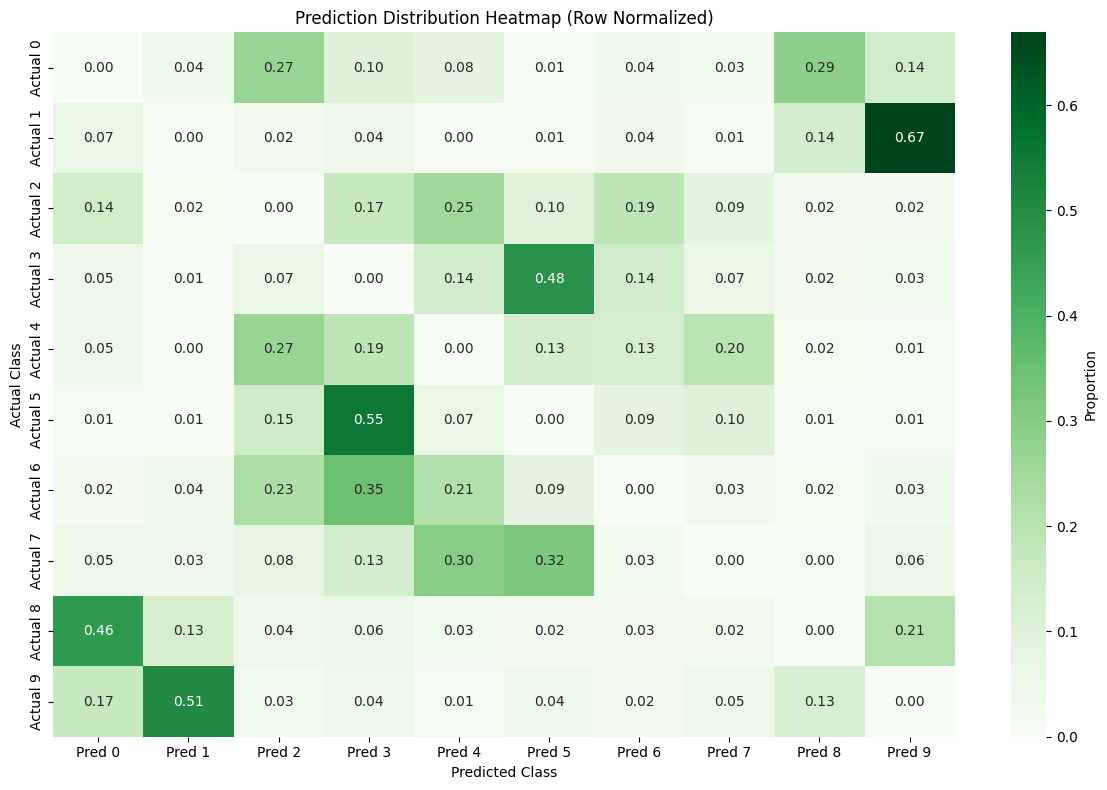

In [4]:
# make heatmap out of csv file
import pandas as pd

df = pd.read_csv("data/results/prediction_distribution/prediction_distribution_target_-1_split_test.csv")

# make heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# every row should be shaded according to how big of a part of the row sum it is 
# Set actual_class as index
df_indexed = df.set_index('actual_class')

# Normalize each row by dividing by row sum (so each row sums to 1)
df_normalized = df_indexed.div(df_indexed.sum(axis=1), axis=0)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_normalized, annot=True, fmt='.2f', cmap='Greens', 
            cbar_kws={'label': 'Proportion'}, 
            xticklabels=[f'Pred {i}' for i in range(10)],
            yticklabels=[f'Actual {i}' for i in range(10)])
plt.title('Prediction Distribution Heatmap (Row Normalized)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()

plt.savefig("data/results/prediction_distribution/prediction_distribution_target_-1_split_test.pdf")
plt.show()


## Load or create regression dataset

In [6]:
dataset["eps_coef_adv"]["train"]

tensor([0.2500, 0.2500, 0.2500,  ..., 2.0000, 2.0000, 2.0000])

In [7]:
from torch.utils.data import Dataset
import torch
from nadf.data.datasets import create_regression_dataset


regression_datasets = {}
clean_upweight_factor = 3.0


for split in ["train", "val", "test"]: 
    y_adv_for_matching = torch.full((len(dataset["y_adv"][split]),), target_class)  # Override to all 9s # Use 9s, not true labels
    print(y_adv_for_matching)
    y_adv = y_adv_for_matching
    if target_class == -1:       
        
        y_adv = dataset["y_adv"][split]
        print(y_adv)

    regression_datasets[split] = create_regression_dataset(
        z_clean = dataset["z_clean"][split],
        y_clean = dataset["y_clean"][split],
        z_adv=dataset["z_adv"][split],
        y_adv=y_adv,  
        clean_upweight_factor=clean_upweight_factor,
        eps_coef_adv=dataset["eps_coef_adv"][split],
        pred_adv=dataset["pred_adv"][split],
        pred_clean=dataset["pred_clean"][split],
        pred_combined=dataset["pred_combined"][split],
    )

tensor([-1, -1, -1,  ..., -1, -1, -1])
tensor([2, 4, 1,  ..., 7, 3, 8])
tensor([-1, -1, -1,  ..., -1, -1, -1])
tensor([4, 8, 4,  ..., 7, 2, 1])
tensor([-1, -1, -1,  ..., -1, -1, -1])
tensor([6, 0, 6,  ..., 9, 7, 0])


In [10]:
# check if eps coef distribution matches up (this is filtered for successful attacks so will not be the same as the original)

print("eps_coefs",regression_datasets["train"][4].unique()) #anchors, distances, labels, weights, eps_coefs, preds

print("preds",regression_datasets["train"][5].unique()) #clean_preds, adv_preds, adv_preds_combined

unique_vals, counts = regression_datasets["train"][4].unique(return_counts=True)
total = counts.sum().item()

print("Distribution of eps_coef values:")
for val, count in zip(unique_vals, counts):
    pct = count.item() / total * 100
    print(f"  {val.item():.2f}: {count.item():5d} ({pct:5.1f}%)")

# print unique labels 
print("unique labels", regression_datasets["train"][2].unique())

eps_coefs tensor([0.0000, 0.2500, 0.5000, 1.0000, 2.0000])
preds tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Distribution of eps_coef values:
  0.00: 45000 ( 21.3%)
  0.25: 16788 (  7.9%)
  0.50: 24609 ( 11.6%)
  1.00: 84459 ( 39.9%)
  2.00: 40791 ( 19.3%)
unique labels tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [11]:
import torch
import os

# After creating the regression dataset
regression_dataset_path = os.path.join(model_folder, "adversarial_examples", str(target_class), "regression_dataset.pt")

# Save the dataset
os.makedirs(os.path.dirname(regression_dataset_path), exist_ok=True)
torch.save(regression_datasets, regression_dataset_path)
print(f"Saved regression dataset to {regression_dataset_path}")

Saved regression dataset to /rds/general/user/nk1924/home/shared_models/cifar10/adam_augbasic_cosine-60-0.0_wd0.01_resnet18repr-128_cifar10_lr0.001_s0/adversarial_examples/-1/regression_dataset.pt


In [12]:
import torch
import os
import dotenv
from argparse import Namespace
from nadf.training.pipeline import train_probe_model
from typing import Dict, Any
import os, glob, torch
from nadf.training.pipeline import load_probe_model


dotenv.load_dotenv()
model_folder = os.getenv("RESNET_MODEL_FOLDER")
target_class = -1
print(model_folder)

regression_dataset_path = os.path.join(model_folder, "adversarial_examples", str(target_class), "regression_dataset.pt")
regression_datasets = torch.load(regression_dataset_path)


/rds/general/user/nk1924/home/shared_models/cifar10/adam_augbasic_cosine-60-0.0_wd0.01_resnet18repr-128_cifar10_lr0.001_s0


In [14]:
# DEBUG
print("eps_coefs",regression_datasets["train"][4].unique()) #anchors, distances, labels, weights, eps_coefs
print("preds",regression_datasets["train"][5].unique()) #clean_preds, adv_preds, adv_preds_combined

# Check for target distances = 0
exact_zeros = regression_datasets["train"][1] == 0
num_exact_zeros = (regression_datasets["train"][1] == 0).sum()

num_exact_zeros

eps_coefs tensor([0.0000, 0.2500, 0.5000, 1.0000, 2.0000])
preds tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor(45000)

In [15]:
# anchors, distances, labels, upweights
regression_datasets["train"][2]

tensor([0, 7, 3,  ..., 7, 3, 8])

Subsampling from 211531 to 5000 samples...
  Class 0 samples: 500
  Class 1 samples: 500
  Class 2 samples: 500
  Class 3 samples: 500
  Class 4 samples: 500
  Class 5 samples: 500
  Class 6 samples: 500
  Class 7 samples: 500
  Class 8 samples: 500
  Class 9 samples: 500
Applying t-SNE...


/rds/general/user/nk1924/home/NADF/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


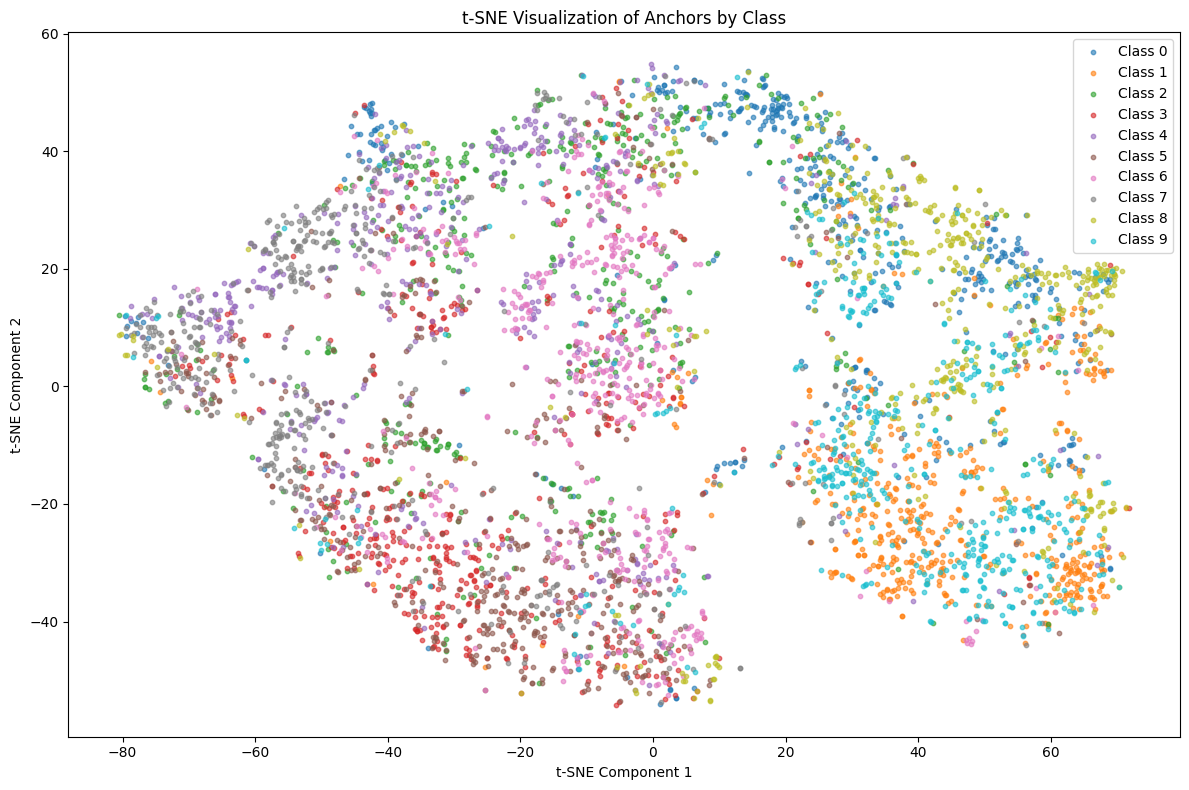


Final dataset size: 5000
Class labels (unique): [0 1 2 3 4 5 6 7 8 9]


In [35]:
# visualize anchors using t-sne
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Choose label type: "class" for class labels from regression_datasets["train"][2], 
#                    "clean_adversarial" for clean/adversarial based on distances
label_type = ["clean_adversarial", "class"][1]  # Change to "class" to use class labels

# Get the anchor points from the regression dataset
anchors = regression_datasets["train"][0]  # Shape: (N, feature_dim)
distances = regression_datasets["train"][1]  # Shape: (N,)
class_labels = regression_datasets["train"][2]  # Shape: (N,) - class labels

# Convert to numpy for sklearn (detach to remove gradient tracking)
anchors_np = anchors.cpu().detach().numpy()
distances_np = distances.cpu().detach().numpy()
class_labels_np = class_labels.cpu().detach().numpy()

# Create clean/adversarial labels: "clean" if distance == 0, "adversarial" if distance > 0
clean_adv_labels = np.where(distances_np == 0, "clean", "adversarial")

# Select labels based on label_type parameter
if label_type == "class":
    visualization_labels = class_labels_np
elif label_type == "clean_adversarial":
    visualization_labels = clean_adv_labels
else:
    raise ValueError(f"label_type must be 'class' or 'clean_adversarial', got '{label_type}'")

# Subsample for faster t-SNE computation
# Set max_samples to None to use all data, or specify a number (e.g., 5000)
max_samples = 5000  # Adjust this based on your dataset size and computational resources

if max_samples is not None and len(anchors_np) > max_samples:
    print(f"Subsampling from {len(anchors_np)} to {max_samples} samples...")
    
    # Stratified subsampling based on visualization labels
    if label_type == "clean_adversarial":
        # Stratified by clean/adversarial
        clean_indices = np.where(clean_adv_labels == "clean")[0]
        adversarial_indices = np.where(clean_adv_labels == "adversarial")[0]
        
        clean_proportion = len(clean_indices) / len(clean_adv_labels)
        n_clean_samples = int(max_samples * clean_proportion)
        n_adversarial_samples = max_samples - n_clean_samples
        
        np.random.seed(42)
        sampled_clean_indices = np.random.choice(clean_indices, size=min(n_clean_samples, len(clean_indices)), replace=False)
        sampled_adv_indices = np.random.choice(adversarial_indices, size=min(n_adversarial_samples, len(adversarial_indices)), replace=False)
        
        sampled_indices = np.concatenate([sampled_clean_indices, sampled_adv_indices])
        print(f"  Clean samples: {len(sampled_clean_indices)}")
        print(f"  Adversarial samples: {len(sampled_adv_indices)}")
    else:
        # Stratified by class labels
        unique_classes = np.unique(class_labels_np)
        sampled_indices_list = []
        
        np.random.seed(42)
        samples_per_class = max_samples // len(unique_classes)
        remainder = max_samples % len(unique_classes)
        
        for i, cls in enumerate(unique_classes):
            class_indices = np.where(class_labels_np == cls)[0]
            n_samples = samples_per_class + (1 if i < remainder else 0)
            n_samples = min(n_samples, len(class_indices))
            sampled_class_indices = np.random.choice(class_indices, size=n_samples, replace=False)
            sampled_indices_list.append(sampled_class_indices)
            print(f"  Class {cls} samples: {n_samples}")
        
        sampled_indices = np.concatenate(sampled_indices_list)
    
    np.random.shuffle(sampled_indices)  # Shuffle for better visualization
    
    # Subsample the data
    anchors_np = anchors_np[sampled_indices]
    class_labels_np = class_labels_np[sampled_indices]
    clean_adv_labels = clean_adv_labels[sampled_indices]
    visualization_labels = visualization_labels[sampled_indices]
    distances_np = distances_np[sampled_indices]

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
anchors_2d = tsne.fit_transform(anchors_np)

# Visualize
plt.figure(figsize=(12, 8))

if label_type == "clean_adversarial":
    # Visualize by clean/adversarial
    for label_val in ["clean", "adversarial"]:
        mask = visualization_labels == label_val
        plt.scatter(anchors_2d[mask, 0], anchors_2d[mask, 1], 
                    label=label_val, alpha=0.6, s=10)
    plt.title("t-SNE Visualization of Anchors (Clean vs Adversarial)")
else:
    # Visualize by class labels (0-9)
    unique_labels = np.unique(visualization_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for i, cls in enumerate(unique_labels):
        mask = visualization_labels == cls
        plt.scatter(anchors_2d[mask, 0], anchors_2d[mask, 1], 
                    label=f"Class {cls}", alpha=0.6, s=10, c=[colors[i]])
    plt.title("t-SNE Visualization of Anchors by Class")

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.tight_layout()

plt.savefig(f"data/results/t-sne_visualization_anchors_target_{target_class}_{label_type}.pdf")
plt.show()

# Print statistics
print(f"\nFinal dataset size: {len(visualization_labels)}")
if label_type == "clean_adversarial":
    num_clean = (visualization_labels == "clean").sum()
    num_adversarial = (visualization_labels == "adversarial").sum()
    print(f"Number of clean samples: {num_clean}")
    print(f"Number of adversarial samples: {num_adversarial}")
print(f"Class labels (unique): {np.unique(class_labels_np)}")

Total samples: 211531
Clean samples: 45000
Subsampling from 45000 to 5000 samples...
  Class 0 samples: 500
  Class 1 samples: 500
  Class 2 samples: 500
  Class 3 samples: 500
  Class 4 samples: 500
  Class 5 samples: 500
  Class 6 samples: 500
  Class 7 samples: 500
  Class 8 samples: 500
  Class 9 samples: 500
Applying t-SNE to clean examples only...


/rds/general/user/nk1924/home/NADF/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


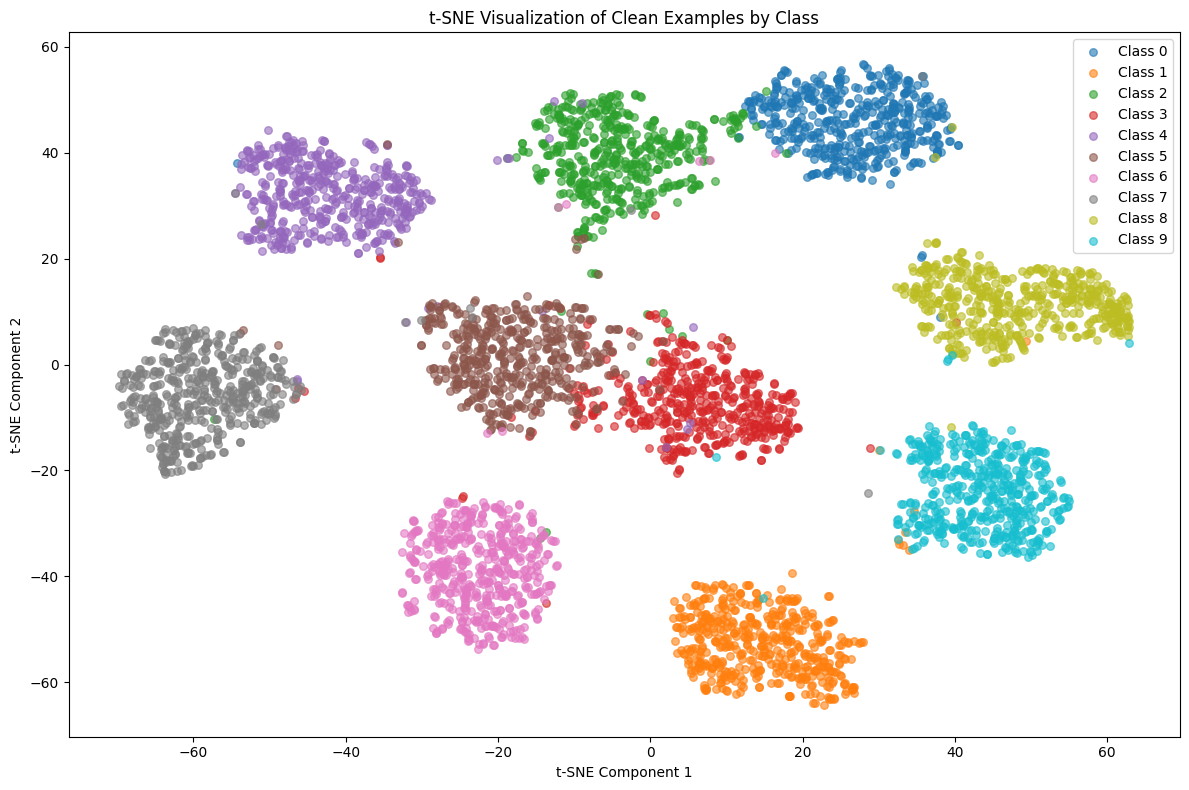


Final dataset size: 5000
Class distribution: [500 500 500 500 500 500 500 500 500 500]


In [53]:
# visualize anchors using t-sne - CLEAN EXAMPLES ONLY
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Get the anchor points from the regression dataset
anchors = regression_datasets["train"][0]  # Shape: (N, feature_dim)
distances = regression_datasets["train"][1]  # Shape: (N,)
class_labels = regression_datasets["train"][2]  # Shape: (N,) - class labels

# Convert to numpy for sklearn (detach to remove gradient tracking)
anchors_np = anchors.cpu().detach().numpy()
distances_np = distances.cpu().detach().numpy()
class_labels_np = class_labels.cpu().detach().numpy()

# Filter to only clean examples (distance == 0)
clean_mask = distances_np == 0
anchors_clean = anchors_np[clean_mask]
class_labels_clean = class_labels_np[clean_mask]

print(f"Total samples: {len(anchors_np)}")
print(f"Clean samples: {len(anchors_clean)}")

# Subsample if needed for faster t-SNE computation
max_samples = 5000  # Adjust this based on your needs

if max_samples is not None and len(anchors_clean) > max_samples:
    print(f"Subsampling from {len(anchors_clean)} to {max_samples} samples...")
    
    # Stratified subsampling by class
    unique_classes = np.unique(class_labels_clean)
    sampled_indices_list = []
    
    np.random.seed(42)
    samples_per_class = max_samples // len(unique_classes)
    remainder = max_samples % len(unique_classes)
    
    for i, cls in enumerate(unique_classes):
        class_indices = np.where(class_labels_clean == cls)[0]
        n_samples = samples_per_class + (1 if i < remainder else 0)
        n_samples = min(n_samples, len(class_indices))
        sampled_class_indices = np.random.choice(class_indices, size=n_samples, replace=False)
        sampled_indices_list.append(sampled_class_indices)
        print(f"  Class {cls} samples: {n_samples}")
    
    sampled_indices = np.concatenate(sampled_indices_list)
    np.random.shuffle(sampled_indices)
    
    # Subsample the data
    anchors_clean = anchors_clean[sampled_indices]
    class_labels_clean = class_labels_clean[sampled_indices]

# Apply t-SNE
print("Applying t-SNE to clean examples only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
anchors_2d = tsne.fit_transform(anchors_clean)

# Visualize by class labels
plt.figure(figsize=(12, 8))

unique_labels = np.unique(class_labels_clean)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, cls in enumerate(unique_labels):
    mask = class_labels_clean == cls
    plt.scatter(anchors_2d[mask, 0], anchors_2d[mask, 1], 
                label=f"Class {cls}", alpha=0.6, s=30, c=[colors[i]])

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Clean Examples by Class")
plt.legend()
plt.tight_layout()

plt.savefig(f"data/results/t-sne_visualization_clean_only_target_{target_class}.pdf")
plt.show()

# Print statistics
print(f"\nFinal dataset size: {len(class_labels_clean)}")
print(f"Class distribution: {np.bincount(class_labels_clean.astype(int))}")

Total samples: 211647
Adversarial samples: 166647
Subsampling from 166647 to 5000 samples...
  Class 0 samples: 500
  Class 1 samples: 500
  Class 2 samples: 500
  Class 3 samples: 500
  Class 4 samples: 500
  Class 5 samples: 500
  Class 6 samples: 500
  Class 7 samples: 500
  Class 8 samples: 500
  Class 9 samples: 500
Applying t-SNE to adversarial examples only...


/rds/general/user/nk1924/home/NADF/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


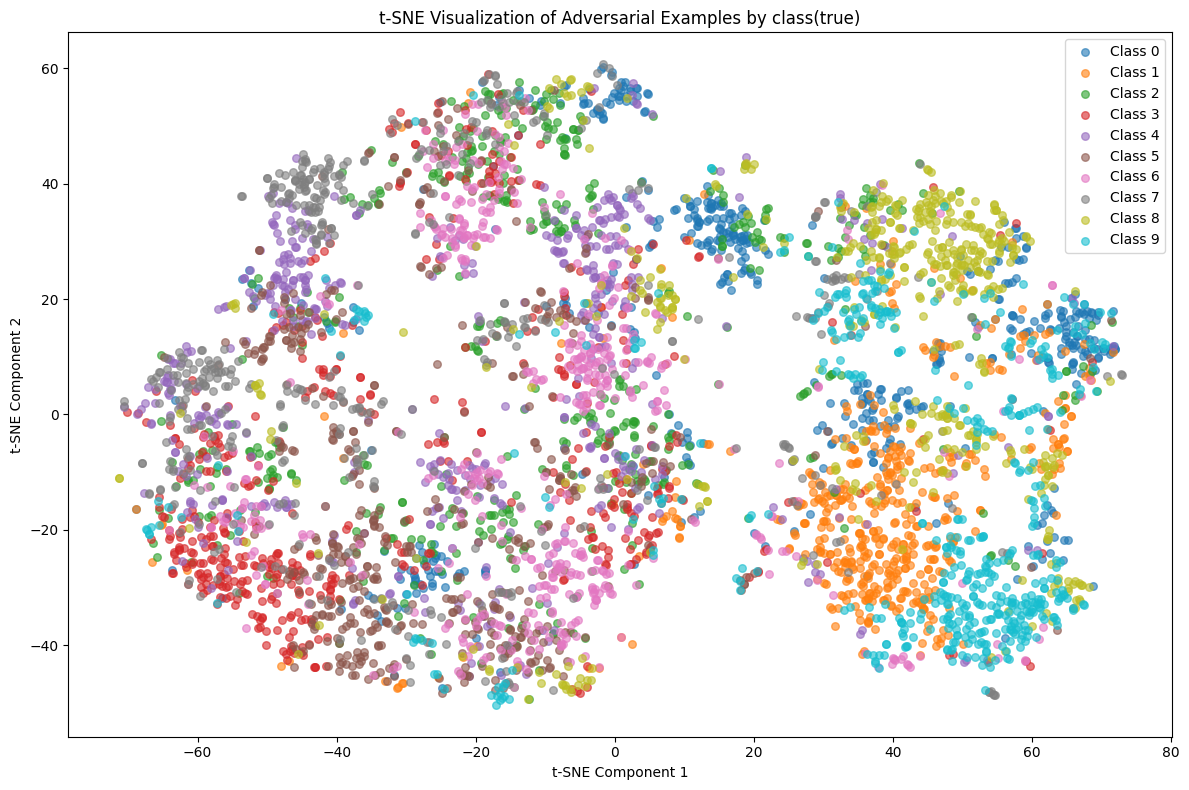


Final dataset size: 5000
Class distribution: [500 500 500 500 500 500 500 500 500 500]


In [17]:
# visualize anchors using t-sne - ADVERSARIAL EXAMPLES ONLY
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Get the anchor points from the regression dataset
anchors = regression_datasets["train"][0]  # Shape: (N, feature_dim)
distances = regression_datasets["train"][1]  # Shape: (N,)
class_labels = regression_datasets["train"][2]  # Shape: (N,) - class labels

# Convert to numpy for sklearn (detach to remove gradient tracking)
anchors_np = anchors.cpu().detach().numpy()
distances_np = distances.cpu().detach().numpy()
class_labels_np = class_labels.cpu().detach().numpy()

# Filter to only adversarial examples (distance > 0)
adv_mask = distances_np > 0
anchors_adv = anchors_np[adv_mask]
class_labels_adv = class_labels_np[adv_mask]

print(f"Total samples: {len(anchors_np)}")
print(f"Adversarial samples: {len(anchors_adv)}")

# Subsample if needed for faster t-SNE computation
max_samples = 5000  # Adjust this based on your needs

if max_samples is not None and len(anchors_adv) > max_samples:
    print(f"Subsampling from {len(anchors_adv)} to {max_samples} samples...")
    
    # Stratified subsampling by class
    unique_classes = np.unique(class_labels_adv)
    sampled_indices_list = []
    
    np.random.seed(42)
    samples_per_class = max_samples // len(unique_classes)
    remainder = max_samples % len(unique_classes)
    
    for i, cls in enumerate(unique_classes):
        class_indices = np.where(class_labels_adv == cls)[0]
        n_samples = samples_per_class + (1 if i < remainder else 0)
        n_samples = min(n_samples, len(class_indices))
        sampled_class_indices = np.random.choice(class_indices, size=n_samples, replace=False)
        sampled_indices_list.append(sampled_class_indices)
        print(f"  Class {cls} samples: {n_samples}")
    
    sampled_indices = np.concatenate(sampled_indices_list)
    np.random.shuffle(sampled_indices)
    
    # Subsample the data
    anchors_adv = anchors_adv[sampled_indices]
    class_labels_adv = class_labels_adv[sampled_indices]

# Apply t-SNE
print("Applying t-SNE to adversarial examples only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
anchors_2d = tsne.fit_transform(anchors_adv)

# Visualize by class labels
plt.figure(figsize=(12, 8))

unique_labels = np.unique(class_labels_adv)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, cls in enumerate(unique_labels):
    mask = class_labels_adv == cls
    plt.scatter(anchors_2d[mask, 0], anchors_2d[mask, 1], 
                label=f"Class {cls}", alpha=0.6, s=30, c=[colors[i]])

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Adversarial Examples by class(true)")
plt.legend()
plt.tight_layout()

plt.savefig(f"data/results/t-sne_visualization_adversarial_only_target_{target_class}.pdf")
plt.show()

# Print statistics
print(f"\nFinal dataset size: {len(class_labels_adv)}")
print(f"Class distribution: {np.bincount(class_labels_adv.astype(int))}")

Total samples: 211647
Adversarial samples: 166647
Subsampling from 166647 to 5000 samples...
  Class 0 samples: 500
  Class 1 samples: 500
  Class 2 samples: 500
  Class 3 samples: 500
  Class 4 samples: 500
  Class 5 samples: 500
  Class 6 samples: 500
  Class 7 samples: 500
  Class 8 samples: 500
  Class 9 samples: 500
Applying t-SNE to adversarial examples only...


/rds/general/user/nk1924/home/NADF/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


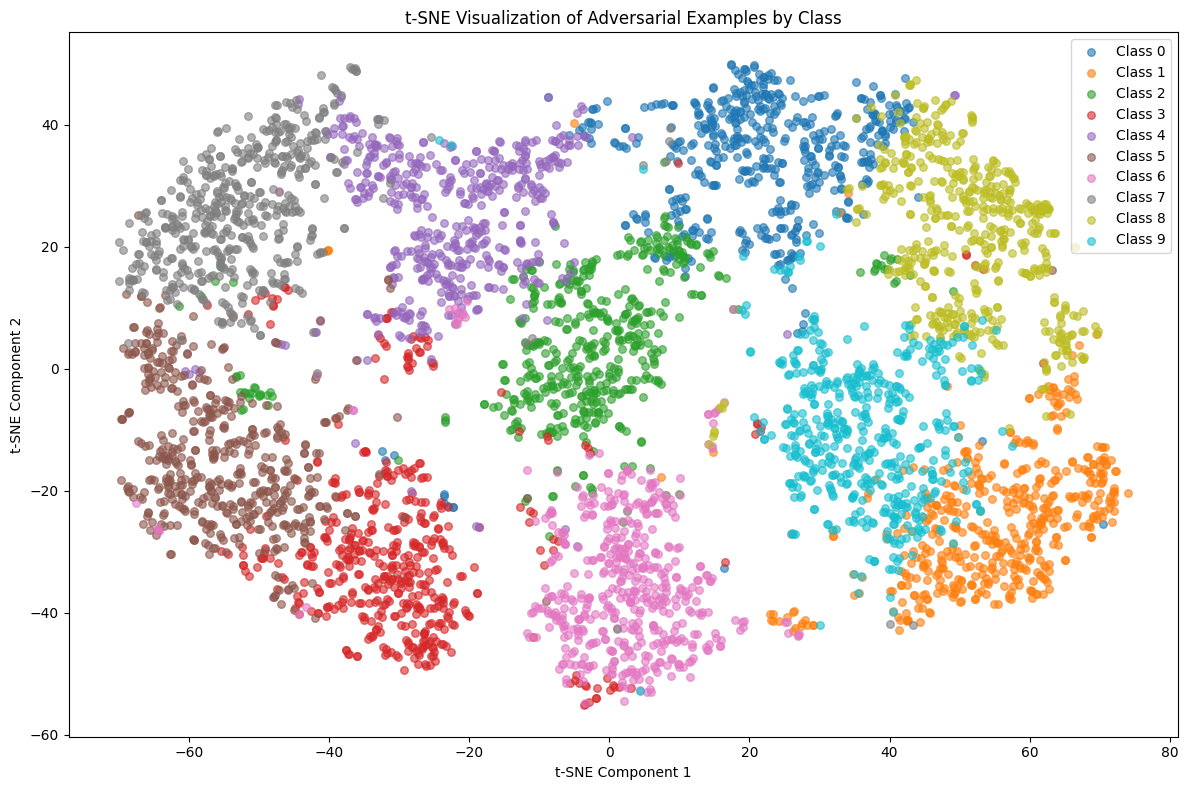


Final dataset size: 5000
Class distribution: [500 500 500 500 500 500 500 500 500 500]


In [ ]:
# visualize anchors using t-sne - ADVERSARIAL EXAMPLES ONLY, use preds as labels


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Get the anchor points from the regression dataset
anchors = regression_datasets["train"][0]  # Shape: (N, feature_dim)
distances = regression_datasets["train"][1]  # Shape: (N,)
class_labels = regression_datasets["train"][5]  # Shape: (N,) - class labels

# Convert to numpy for sklearn (detach to remove gradient tracking)
anchors_np = anchors.cpu().detach().numpy()
distances_np = distances.cpu().detach().numpy()
class_labels_np = class_labels.cpu().detach().numpy()

# Filter to only adversarial examples (distance > 0)
adv_mask = distances_np > 0
anchors_adv = anchors_np[adv_mask]
class_labels_adv = class_labels_np[adv_mask]

print(f"Total samples: {len(anchors_np)}")
print(f"Adversarial samples: {len(anchors_adv)}")

# Subsample if needed for faster t-SNE computation
max_samples = 5000  # Adjust this based on your needs

if max_samples is not None and len(anchors_adv) > max_samples:
    print(f"Subsampling from {len(anchors_adv)} to {max_samples} samples...")
    
    # Stratified subsampling by class
    unique_classes = np.unique(class_labels_adv)
    sampled_indices_list = []
    
    np.random.seed(42)
    samples_per_class = max_samples // len(unique_classes)
    remainder = max_samples % len(unique_classes)
    
    for i, cls in enumerate(unique_classes):
        class_indices = np.where(class_labels_adv == cls)[0]
        n_samples = samples_per_class + (1 if i < remainder else 0)
        n_samples = min(n_samples, len(class_indices))
        sampled_class_indices = np.random.choice(class_indices, size=n_samples, replace=False)
        sampled_indices_list.append(sampled_class_indices)
        print(f"  Class {cls} samples: {n_samples}")
    
    sampled_indices = np.concatenate(sampled_indices_list)
    np.random.shuffle(sampled_indices)
    
    # Subsample the data
    anchors_adv = anchors_adv[sampled_indices]
    class_labels_adv = class_labels_adv[sampled_indices]

# Apply t-SNE
print("Applying t-SNE to adversarial examples only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
anchors_2d = tsne.fit_transform(anchors_adv)

# Visualize by class labels
plt.figure(figsize=(12, 8))

unique_labels = np.unique(class_labels_adv)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for i, cls in enumerate(unique_labels):
    mask = class_labels_adv == cls
    plt.scatter(anchors_2d[mask, 0], anchors_2d[mask, 1], 
                label=f"Class {cls}", alpha=0.6, s=30, c=[colors[i]])

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Adversarial Examples by class(predicted)")
plt.legend()
plt.tight_layout()

plt.savefig(f"data/results/t-sne_visualization_adversarial_only_target_{target_class}.pdf")
plt.show()

# Print statistics
print(f"\nFinal dataset size: {len(class_labels_adv)}")
print(f"Class distribution: {np.bincount(class_labels_adv.astype(int))}")

Subsampling from 211647 to 5000 samples...
  Clean: 1063, Adversarial: 3937
Applying t-SNE...


/rds/general/user/nk1924/home/NADF/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


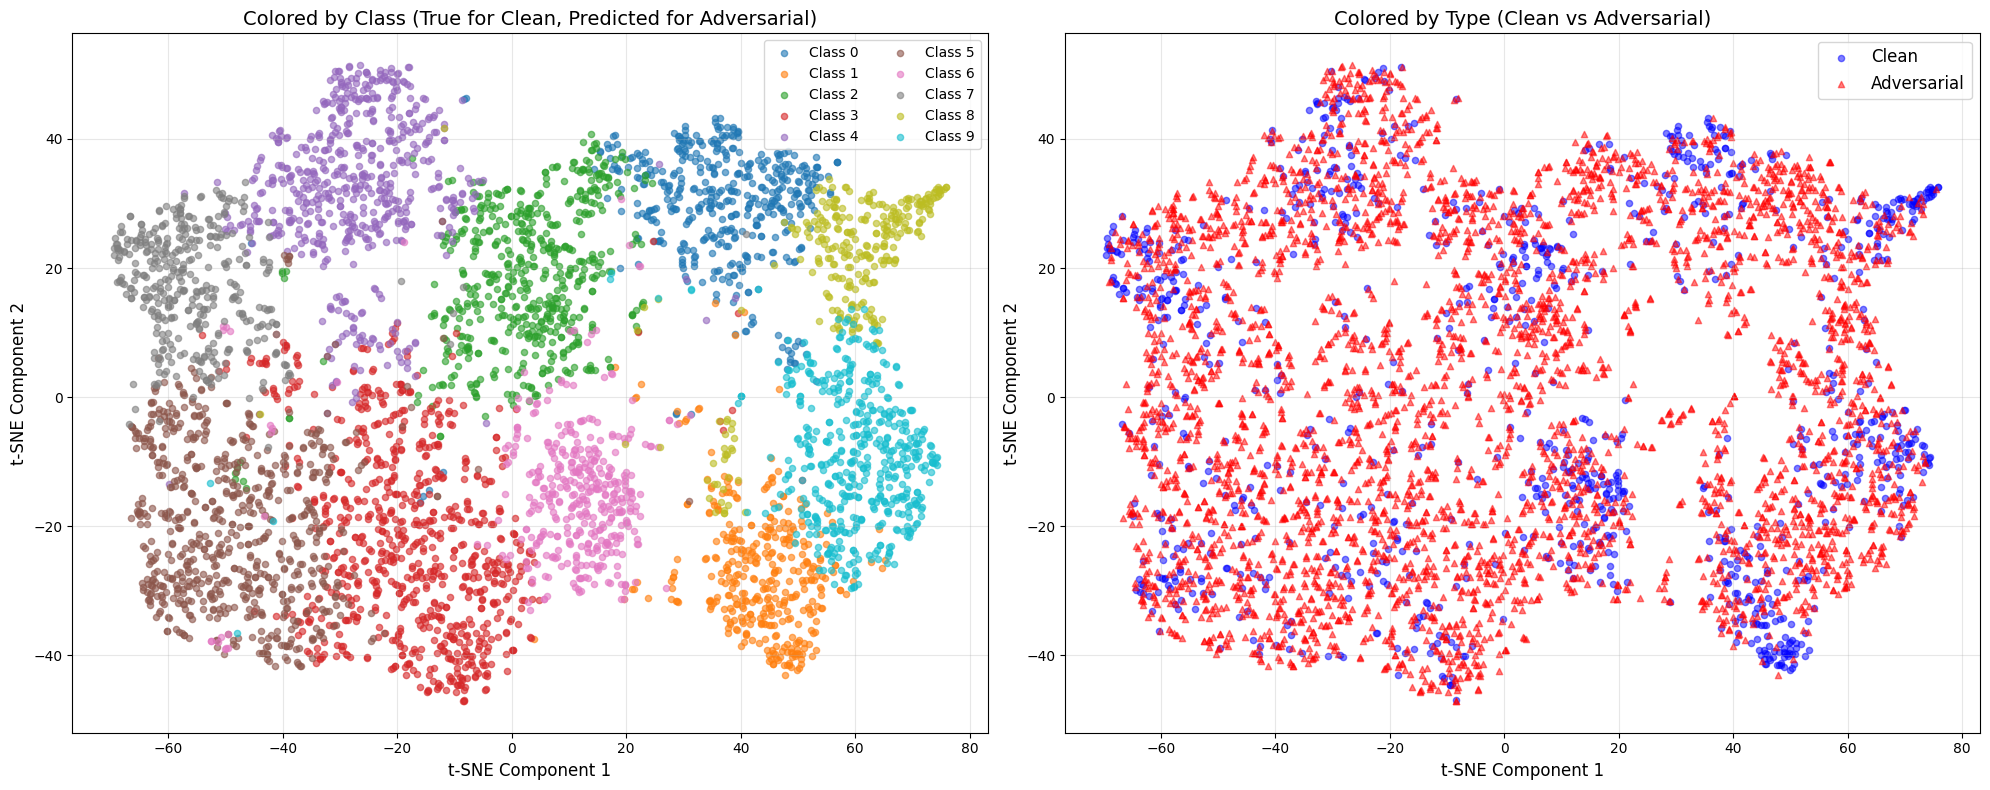


Visualization statistics:
  Total samples: 5000
  Clean samples: 1063
  Adversarial samples: 3937
  Class distribution: [448 370 561 777 585 689 403 385 294 488]


In [19]:
# t-sne of adversarial and clean examples, using true labels for clean and predicted labels for adversarial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

split = "train"  # or "val" or "test"

# Get representations
z_clean = dataset["z_clean"][split]
z_adv = dataset["z_adv"][split]

# Get labels
y_clean_true = dataset["y_clean"][split]  # True labels for clean
pred_clean = dataset["pred_clean"][split]  # Predictions for clean
pred_adv = dataset["pred_adv"][split]  # Predictions for adversarial

# Combine representations
z_all = torch.cat([z_clean, z_adv], dim=0)

# Create visualization labels: true labels for clean, predicted labels for adversarial
viz_labels = torch.cat([y_clean_true, pred_adv], dim=0)

# Create type labels (clean vs adversarial)
type_labels = np.array(['clean'] * len(z_clean) + ['adversarial'] * len(z_adv))

# Convert to numpy
z_all_np = z_all.cpu().detach().numpy()
viz_labels_np = viz_labels.cpu().detach().numpy()

# Subsample for faster t-SNE
max_samples = 5000
if len(z_all_np) > max_samples:
    print(f"Subsampling from {len(z_all_np)} to {max_samples} samples...")
    
    # Stratified sampling by type (clean/adversarial)
    clean_indices = np.where(type_labels == 'clean')[0]
    adv_indices = np.where(type_labels == 'adversarial')[0]
    
    n_clean = int(max_samples * len(clean_indices) / len(z_all_np))
    n_adv = max_samples - n_clean
    
    np.random.seed(42)
    sampled_clean = np.random.choice(clean_indices, size=min(n_clean, len(clean_indices)), replace=False)
    sampled_adv = np.random.choice(adv_indices, size=min(n_adv, len(adv_indices)), replace=False)
    
    sampled_indices = np.concatenate([sampled_clean, sampled_adv])
    np.random.shuffle(sampled_indices)
    
    z_all_np = z_all_np[sampled_indices]
    viz_labels_np = viz_labels_np[sampled_indices]
    type_labels = type_labels[sampled_indices]
    
    print(f"  Clean: {len(sampled_clean)}, Adversarial: {len(sampled_adv)}")

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
z_2d = tsne.fit_transform(z_all_np)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: colored by class (true for clean, predicted for adversarial)
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for cls in range(10):
    mask = viz_labels_np == cls
    ax1.scatter(z_2d[mask, 0], z_2d[mask, 1], 
                label=f"Class {cls}", alpha=0.6, s=20, c=[colors[cls]])
ax1.set_xlabel("t-SNE Component 1", fontsize=12)
ax1.set_ylabel("t-SNE Component 2", fontsize=12)
ax1.set_title("Colored by Class (True for Clean, Predicted for Adversarial)", fontsize=14)
ax1.legend(ncol=2, fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: colored by type (clean vs adversarial)
for typ, color, marker in [('clean', 'blue', 'o'), ('adversarial', 'red', '^')]:
    mask = type_labels == typ
    ax2.scatter(z_2d[mask, 0], z_2d[mask, 1], 
                label=typ.capitalize(), alpha=0.5, s=20, c=color, marker=marker)
ax2.set_xlabel("t-SNE Component 1", fontsize=12)
ax2.set_ylabel("t-SNE Component 2", fontsize=12)
ax2.set_title("Colored by Type (Clean vs Adversarial)", fontsize=14)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"data/results/tsne_clean_vs_adv_predictions_{split}.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nVisualization statistics:")
print(f"  Total samples: {len(z_2d)}")
print(f"  Clean samples: {(type_labels == 'clean').sum()}")
print(f"  Adversarial samples: {(type_labels == 'adversarial').sum()}")
print(f"  Class distribution: {np.bincount(viz_labels_np.astype(int))}")

# Do stronger attacks lie farther away from the manifold ? 

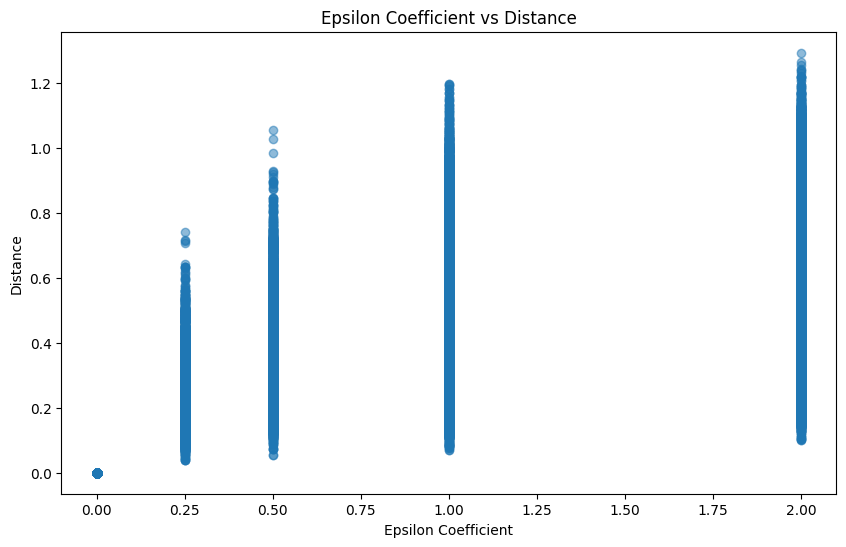

In [20]:
# plot the eps_coefs against the distances
plt.figure(figsize=(10, 6))
plt.scatter(regression_datasets["train"][4], regression_datasets["train"][1], alpha=0.5)
plt.xlabel("Epsilon Coefficient")
plt.ylabel("Distance")
plt.title("Epsilon Coefficient vs Distance")
plt.show()

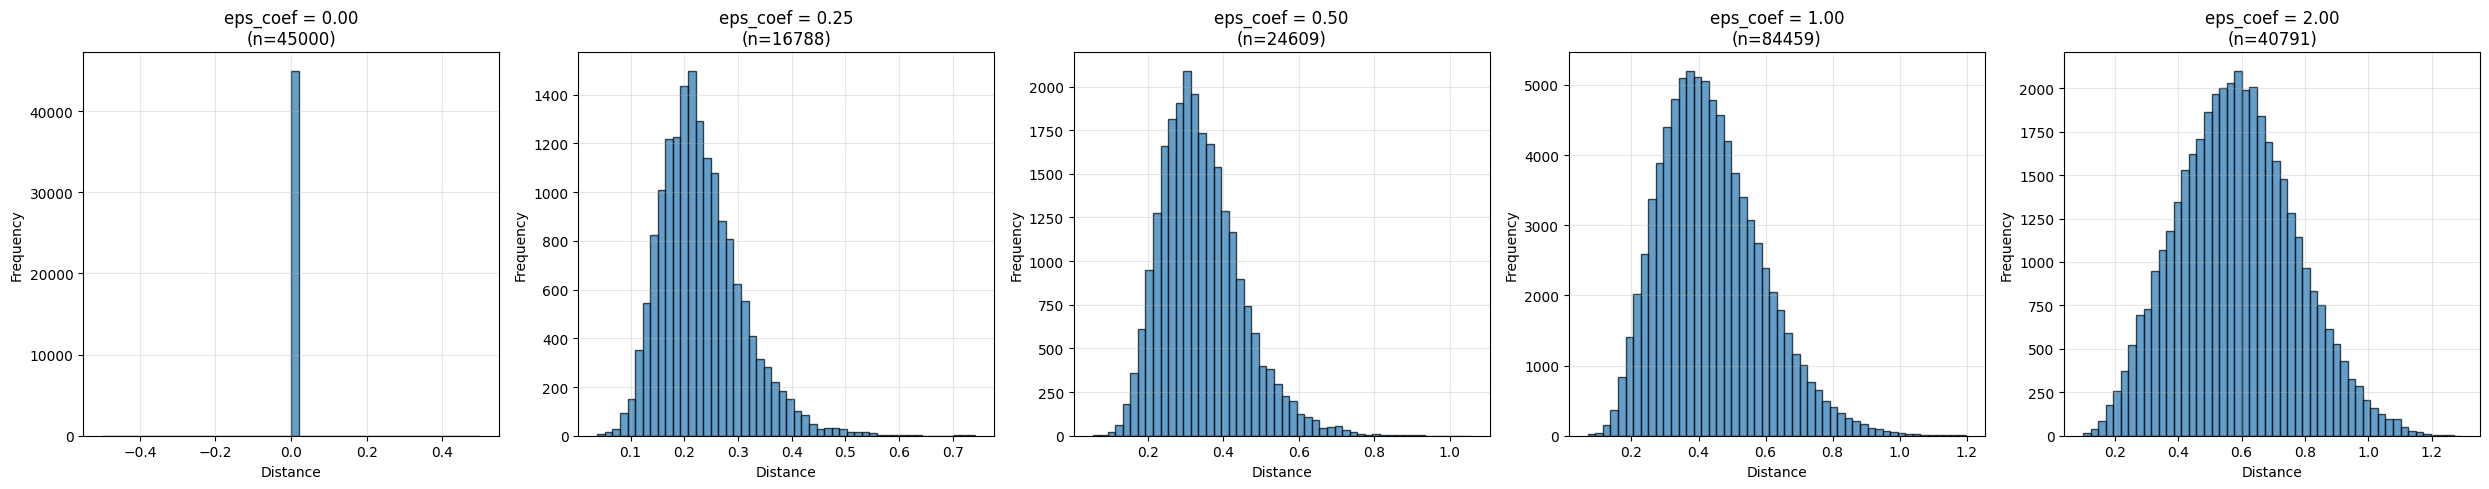

In [21]:
import matplotlib.pyplot as plt
import torch

eps_coefs = regression_datasets["train"][4]
distances = regression_datasets["train"][1]

# Get unique eps_coef values
unique_eps = eps_coefs.unique().sort()[0]

# Create subplots - one for each eps_coef value
n_unique = len(unique_eps)
fig, axes = plt.subplots(1, n_unique, figsize=(5 * n_unique, 5))

# Handle case where there's only one unique value
if n_unique == 1:
    axes = [axes]

for i, eps_val in enumerate(unique_eps):
    # Filter distances for this eps_coef value
    mask = eps_coefs == eps_val
    distances_for_eps = distances[mask]
    
    # Plot histogram
    axes[i].hist(distances_for_eps.numpy(), bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_xlabel("Distance")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"eps_coef = {eps_val.item():.2f}\n(n={mask.sum().item()})")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

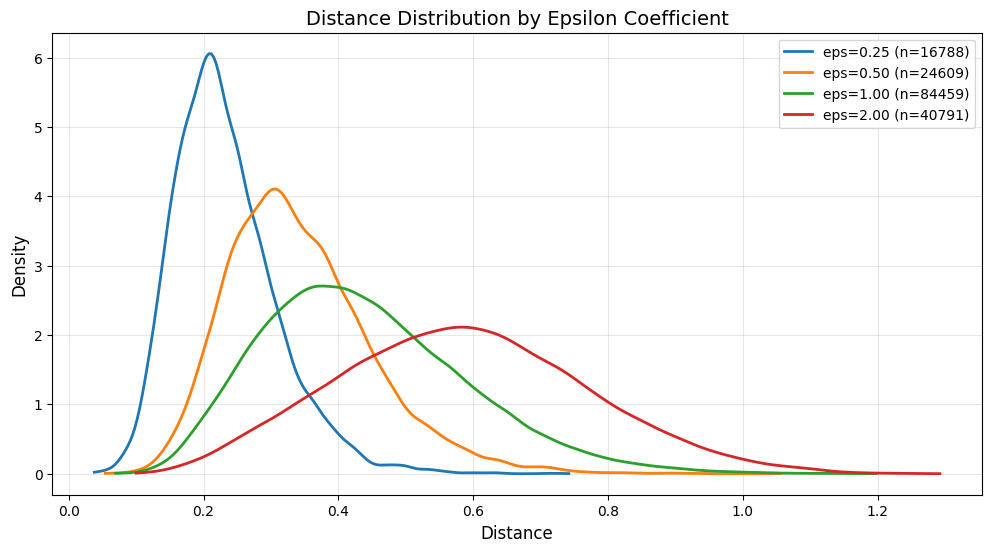

In [22]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

eps_coefs = regression_datasets["train"][4]
distances = regression_datasets["train"][1]
unique_eps = eps_coefs.unique().sort()[0]

plt.figure(figsize=(12, 6))

for eps_val in unique_eps:
    if eps_val == 0.0:  # Skip eps=0.0
        continue
        
    mask = eps_coefs == eps_val
    distances_for_eps = distances[mask].numpy()
    
    kde = stats.gaussian_kde(distances_for_eps)
    x_range = np.linspace(distances_for_eps.min(), distances_for_eps.max(), 200)
    density = kde(x_range)
    plt.plot(x_range, density, linewidth=2, 
             label=f"eps={eps_val.item():.2f} (n={mask.sum().item()})")

plt.xlabel("Distance", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distance Distribution by Epsilon Coefficient", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

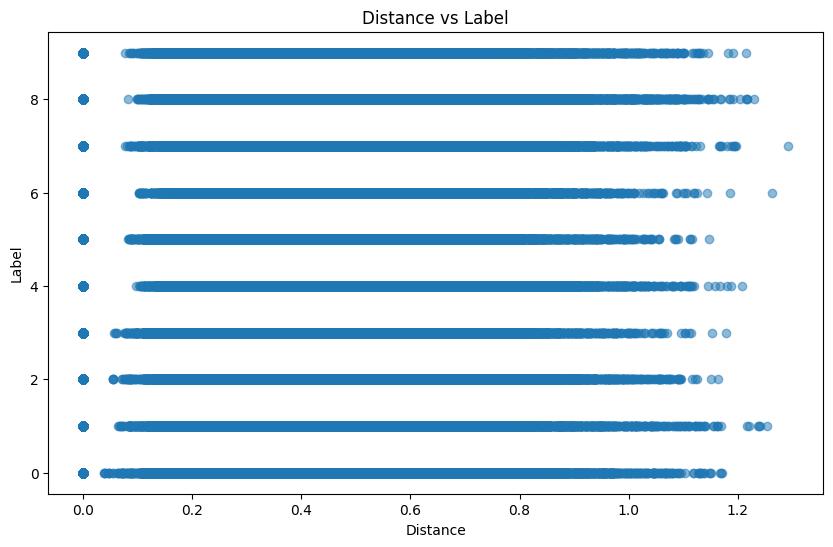

In [23]:
# plot labels against distances
plt.figure(figsize=(10, 6))
plt.scatter(regression_datasets["train"][1], regression_datasets["train"][2], alpha=0.5)
plt.xlabel("Distance")
plt.ylabel("Label")
plt.title("Distance vs Label")
plt.show()

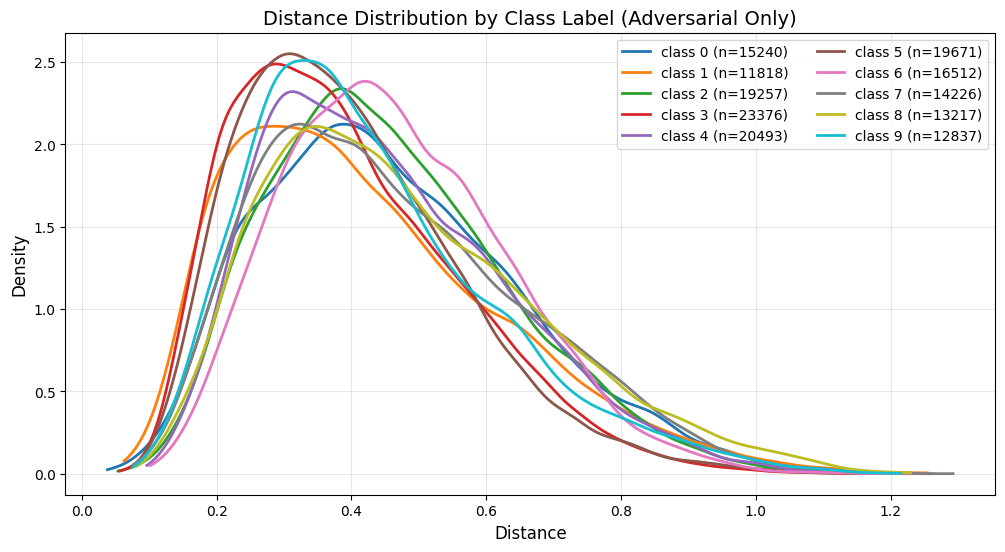

In [24]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

labels = regression_datasets["train"][2]
distances = regression_datasets["train"][1]
eps_coefs = regression_datasets["train"][4]

# Filter out clean examples (eps_coef == 0)
mask_adv = eps_coefs != 0.0
labels_adv = labels[mask_adv]
distances_adv = distances[mask_adv]

unique_labels = labels_adv.unique().sort()[0]

plt.figure(figsize=(12, 6))

for label in unique_labels:
    mask = labels_adv == label
    distances_for_label = distances_adv[mask].numpy()
    
    kde = stats.gaussian_kde(distances_for_label)
    x_range = np.linspace(distances_for_label.min(), distances_for_label.max(), 200)
    density = kde(x_range)
    plt.plot(x_range, density, linewidth=2, 
             label=f"class {label.item()} (n={mask.sum().item()})")

plt.xlabel("Distance", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distance Distribution by Class Label (Adversarial Only)", fontsize=14)
plt.legend(fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()


Distance Statistics by Epsilon Coefficient:
 eps_coef  count  mean_distance  std_distance  min_distance  median_distance  max_distance  q25_distance  q75_distance  accuracy
     0.00  45000       0.000000      0.000000      0.000000         0.000000      0.000000      0.000000      0.000000  0.979156
     0.25  16788       0.231937      0.075813      0.038187         0.221048      0.741899      0.178328      0.274439  0.000000
     0.50  24609       0.342512      0.107215      0.054328         0.328031      1.055349      0.265745      0.403782  0.000000
     1.00  84459       0.438484      0.151392      0.069678         0.421044      1.197457      0.327497      0.531809  0.000000
     2.00  40791       0.584535      0.184746      0.100122         0.579667      1.292352      0.452058      0.708664  0.000000

Saved statistics to: data/results/distance_statistics_by_eps_coef_target_-1.csv


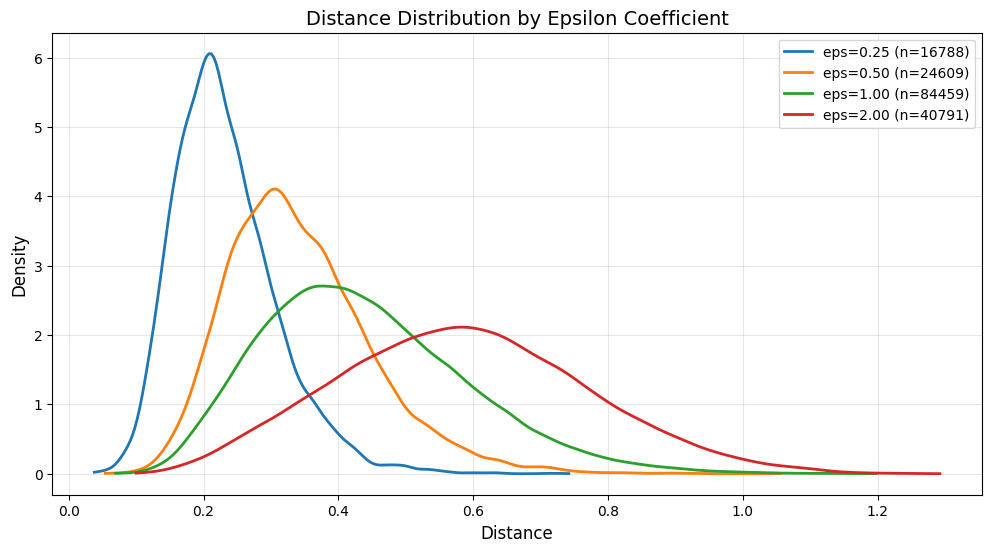

In [25]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

eps_coefs = regression_datasets["train"][4]
distances = regression_datasets["train"][1]
predictions = regression_datasets["train"][5]  # Assuming this is the predictions from your modified function
labels = regression_datasets["train"][2]  # True labels

unique_eps = eps_coefs.unique().sort()[0]

# Create summary statistics for each eps_coef
summary_data = []

for eps_val in unique_eps:
    mask = eps_coefs == eps_val
    distances_for_eps = distances[mask].numpy()
    
    # Calculate statistics
    stats_dict = {
        'eps_coef': eps_val.item(),
        'count': mask.sum().item(),
        'mean_distance': distances_for_eps.mean(),
        'std_distance': distances_for_eps.std(),
        'min_distance': distances_for_eps.min(),
        'median_distance': np.median(distances_for_eps),
        'max_distance': distances_for_eps.max(),
        'q25_distance': np.percentile(distances_for_eps, 25),
        'q75_distance': np.percentile(distances_for_eps, 75),
    }
    
    # Add accuracy if predictions are available
    if predictions is not None and not torch.isnan(predictions).all():
        preds_for_eps = predictions[mask]
        labels_for_eps = labels[mask]
        # Filter out NaN predictions (clean examples)
        valid_mask = ~torch.isnan(preds_for_eps)
        if valid_mask.sum() > 0:
            accuracy = (preds_for_eps[valid_mask] == labels_for_eps[valid_mask]).float().mean().item()
            stats_dict['accuracy'] = accuracy
    
    summary_data.append(stats_dict)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Print the table
print("\nDistance Statistics by Epsilon Coefficient:")
print("=" * 100)
print(summary_df.to_string(index=False))
print("=" * 100)

# Save to CSV
output_path = f"data/results/distance_statistics_by_eps_coef_target_{target_class}.csv"
summary_df.to_csv(output_path, index=False)
print(f"\nSaved statistics to: {output_path}")

# Plot (your existing plot)
plt.figure(figsize=(12, 6))

for eps_val in unique_eps:
    if eps_val == 0.0:  # Skip eps=0.0
        continue
        
    mask = eps_coefs == eps_val
    distances_for_eps = distances[mask].numpy()
    
    kde = stats.gaussian_kde(distances_for_eps)
    x_range = np.linspace(distances_for_eps.min(), distances_for_eps.max(), 200)
    density = kde(x_range)
    plt.plot(x_range, density, linewidth=2, 
             label=f"eps={eps_val.item():.2f} (n={mask.sum().item()})")

plt.xlabel("Distance", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distance Distribution by Epsilon Coefficient", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig(f"data/results/distance_distribution_by_eps_coef_target_{target_class}.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Comparing distances to cosine similarities 


Distance to Cosine Similarity Conversion Table
 Distance  Cosine Similarity  Angle (degrees)   Interpretation
   0.0500             0.9988           2.8651     Very similar
   0.1000             0.9950           5.7320     Very similar
   0.1500             0.9888           8.6024     Very similar
   0.2000             0.9800          11.4783          Similar
   0.2500             0.9688          14.3615          Similar
   0.3000             0.9550          17.2539          Similar
   0.3500             0.9387          20.1573          Similar
   0.4000             0.9200          23.0739          Similar
   0.4500             0.8987          26.0058          Similar
   0.5000             0.8750          28.9550 Somewhat similar
   0.5500             0.8488          31.9240 Somewhat similar
   0.6000             0.8200          34.9152 Somewhat similar
   0.6500             0.7887          37.9311 Somewhat similar
   0.7000             0.7550          40.9746 Somewhat similar
   0.75

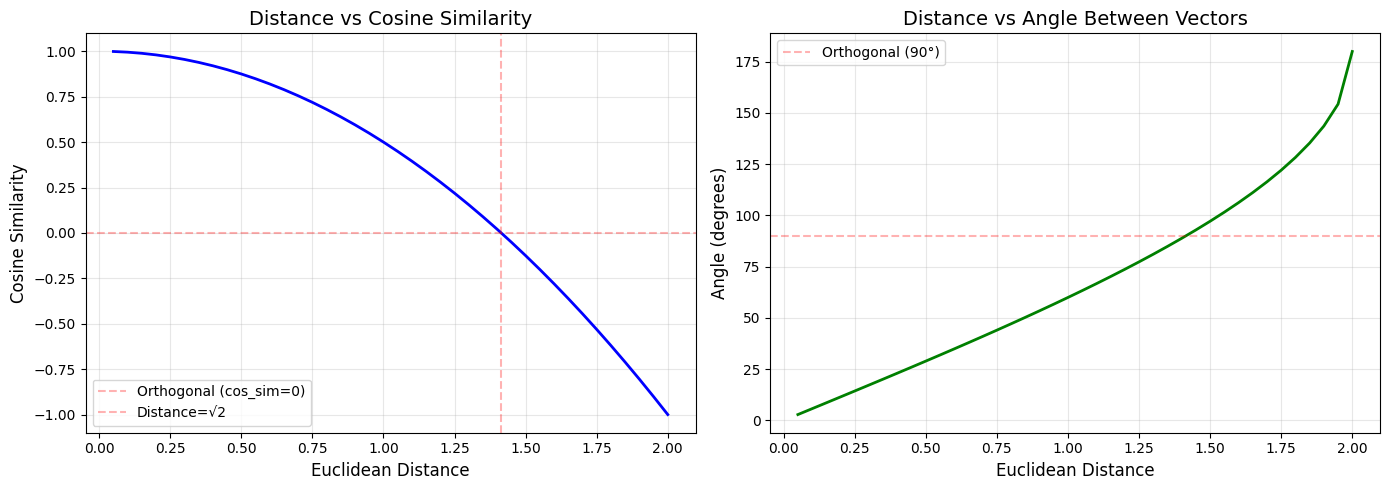

In [27]:
import pandas as pd
import numpy as np

# Create distance values from 0.05 to 2.0 in steps of 0.05
distances_to_check = np.arange(0.05, 2.05, 0.05)

# Calculate corresponding cosine similarities
def distance_to_cosine_similarity(distance):
    return 1.0 - (distance ** 2) / 2.0

cosine_sims = distance_to_cosine_similarity(distances_to_check)

# Also calculate the angle between vectors (in degrees)
# For normalized vectors: cosine_similarity = cos(angle)
angles_deg = np.arccos(np.clip(cosine_sims, -1, 1)) * 180 / np.pi

# Create DataFrame
conversion_df = pd.DataFrame({
    'Distance': distances_to_check,
    'Cosine Similarity': cosine_sims,
    'Angle (degrees)': angles_deg,
    'Interpretation': [''] * len(distances_to_check)
})

# Add interpretations for key values
for idx, row in conversion_df.iterrows():
    dist = row['Distance']
    cos_sim = row['Cosine Similarity']
    
    if dist < 0.2:
        conversion_df.loc[idx, 'Interpretation'] = 'Very similar'
    elif dist < 0.5:
        conversion_df.loc[idx, 'Interpretation'] = 'Similar'
    elif dist < 1.0:
        conversion_df.loc[idx, 'Interpretation'] = 'Somewhat similar'
    elif dist < 1.414:
        conversion_df.loc[idx, 'Interpretation'] = 'Dissimilar'
    elif dist < 1.8:
        conversion_df.loc[idx, 'Interpretation'] = 'Very dissimilar'
    else:
        conversion_df.loc[idx, 'Interpretation'] = 'Nearly opposite'

# Print the table
print("\nDistance to Cosine Similarity Conversion Table")
print("=" * 90)
print(conversion_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("=" * 90)

# Highlight key values
print("\nKey reference points:")
print(f"  Distance = 0.00  → Cosine Similarity = 1.00   (identical vectors, 0°)")
print(f"  Distance = 1.41  → Cosine Similarity = 0.00   (orthogonal vectors, 90°)")
print(f"  Distance = 2.00  → Cosine Similarity = -1.00  (opposite vectors, 180°)")

# Save to CSV
output_path = "data/results/distance_to_cosine_similarity_conversion.csv"
conversion_df.to_csv(output_path, index=False)
print(f"\nSaved conversion table to: {output_path}")

# Visualize the relationship
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distance vs Cosine Similarity
ax1.plot(distances_to_check, cosine_sims, 'b-', linewidth=2)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='Orthogonal (cos_sim=0)')
ax1.axvline(x=np.sqrt(2), color='r', linestyle='--', alpha=0.3, label='Distance=√2')
ax1.set_xlabel('Euclidean Distance', fontsize=12)
ax1.set_ylabel('Cosine Similarity', fontsize=12)
ax1.set_title('Distance vs Cosine Similarity', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Distance vs Angle
ax2.plot(distances_to_check, angles_deg, 'g-', linewidth=2)
ax2.axhline(y=90, color='r', linestyle='--', alpha=0.3, label='Orthogonal (90°)')
ax2.set_xlabel('Euclidean Distance', fontsize=12)
ax2.set_ylabel('Angle (degrees)', fontsize=12)
ax2.set_title('Distance vs Angle Between Vectors', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("data/results/distance_cosine_relationship.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
import pandas as pd
import numpy as np
from scipy import stats as scipy_stats

eps_coefs = regression_datasets["train"][4]
distances = regression_datasets["train"][1]

# Convert distance to cosine similarity
def distance_to_cosine_similarity(distance):
    return 1.0 - (distance ** 2) / 2.0

# Filter out clean examples (eps=0) for adversarial-only analysis
adv_mask = eps_coefs > 0
distances_adv = distances[adv_mask]
eps_coefs_adv = eps_coefs[adv_mask]

print("\n" + "="*100)
print("DISTANCE STATISTICS (ADVERSARIAL EXAMPLES ONLY)")
print("="*100)

# Calculate statistics
min_dist = distances_adv.min().item()
max_dist = distances_adv.max().item()
mean_dist = distances_adv.mean().item()
median_dist = distances_adv.median().item()

# Mode (most frequent distance, binned)
hist, bin_edges = np.histogram(distances_adv.numpy(), bins=100)
mode_idx = hist.argmax()
mode_dist = (bin_edges[mode_idx] + bin_edges[mode_idx + 1]) / 2

# Q1 and Q3 for additional context
q1_dist = distances_adv.quantile(0.25).item()
q3_dist = distances_adv.quantile(0.75).item()

# Find which eps_coef corresponds to each statistic
def find_eps_for_distance(target_dist, distances, eps_coefs, tolerance=0.01):
    """Find eps_coef values near the target distance"""
    mask = torch.abs(distances - target_dist) < tolerance
    if mask.sum() > 0:
        eps_vals = eps_coefs[mask].unique()
        return eps_vals.numpy().tolist()
    return []

# Create statistics table
stats_data = []

for stat_name, stat_value in [
    ('Minimum', min_dist),
    ('Q1 (25%)', q1_dist),
    ('Median', median_dist),
    ('Mean', mean_dist),
    ('Mode', mode_dist),
    ('Q3 (75%)', q3_dist),
    ('Maximum', max_dist),
]:
    # Find corresponding eps values
    eps_vals = find_eps_for_distance(stat_value, distances_adv, eps_coefs_adv, tolerance=0.05)
    
    # Convert to cosine similarity
    cos_sim = distance_to_cosine_similarity(stat_value)
    
    # Calculate angle
    angle = np.arccos(np.clip(cos_sim, -1, 1)) * 180 / np.pi
    
    stats_data.append({
        'Statistic': stat_name,
        'Distance': stat_value,
        'Cosine Similarity': cos_sim,
        'Angle (deg)': angle,
        'Common eps_coef': ', '.join([f'{e:.2f}' for e in sorted(set(eps_vals))]) if eps_vals else 'Various'
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*100)

# Statistics by eps_coef
print("\nDISTANCE STATISTICS BY ATTACK STRENGTH")
print("="*100)

grouped_data = []
for eps_val in sorted(eps_coefs_adv.unique()):
    mask = eps_coefs_adv == eps_val
    dists = distances_adv[mask]
    
    if len(dists) > 0:
        grouped_data.append({
            'eps_coef': eps_val.item(),
            'count': len(dists),
            'min_dist': dists.min().item(),
            'mean_dist': dists.mean().item(),
            'median_dist': dists.median().item(),
            'max_dist': dists.max().item(),
            'min_cos_sim': distance_to_cosine_similarity(dists.max().item()),
            'mean_cos_sim': distance_to_cosine_similarity(dists.mean().item()),
            'median_cos_sim': distance_to_cosine_similarity(dists.median().item()),
            'max_cos_sim': distance_to_cosine_similarity(dists.min().item()),
        })

grouped_df = pd.DataFrame(grouped_data)
print(grouped_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*100)

# Overall statistics
print(f"\nOVERALL STATISTICS:")
print(f"  Total adversarial examples: {len(distances_adv)}")
print(f"  Distance range: [{min_dist:.4f}, {max_dist:.4f}]")
print(f"  Cosine similarity range: [{distance_to_cosine_similarity(max_dist):.4f}, {distance_to_cosine_similarity(min_dist):.4f}]")
print(f"  Standard deviation: {distances_adv.std().item():.4f}")

# Save to CSV
stats_df.to_csv("data/results/distance_statistics_summary.csv", index=False)
grouped_df.to_csv("data/results/distance_statistics_by_eps.csv", index=False)
print(f"\nSaved to:")
print(f"  - data/results/distance_statistics_summary.csv")
print(f"  - data/results/distance_statistics_by_eps.csv")


DISTANCE STATISTICS (ADVERSARIAL EXAMPLES ONLY)
Statistic  Distance  Cosine Similarity  Angle (deg)        Common eps_coef
  Minimum    0.0382             0.9993       2.1881       0.25, 0.50, 1.00
 Q1 (25%)    0.3006             0.9548      17.2884 0.25, 0.50, 1.00, 2.00
   Median    0.4127             0.9149      23.8144 0.25, 0.50, 1.00, 2.00
     Mean    0.4393             0.9035      25.3743 0.25, 0.50, 1.00, 2.00
     Mode    0.3580             0.9359      20.6230 0.25, 0.50, 1.00, 2.00
 Q3 (75%)    0.5536             0.8468      32.1398 0.25, 0.50, 1.00, 2.00
  Maximum    1.2924             0.1649      80.5078                   2.00

DISTANCE STATISTICS BY ATTACK STRENGTH
 eps_coef  count  min_dist  mean_dist  median_dist  max_dist  min_cos_sim  mean_cos_sim  median_cos_sim  max_cos_sim
   0.2500  16788    0.0382     0.2319       0.2210    0.7419       0.7248        0.9731          0.9756       0.9993
   0.5000  24609    0.0543     0.3425       0.3280    1.0553       0.4431    